# Práctico Deep Learning para Recomendación

Diplomado Machine Learning Aplicado, PUC Chile

**Profesor:** Vicente Domínguez

**Alumno:** `Sebastián Latorre Diaz`

En esta actividad trabajaremos con un recomendador de ropa basado netamente en las imagenes más similares extrayendo features con redes neuronales convolucionales.



In [ ]:
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

En esta sección se trabajará con modelos pre-entrenados de redes convolucionales (CNN) que extraen caracteristicas visuales de las imagenes.

![Ejemplo de red convolucional](http://dparra.sitios.ing.uc.cl/img/alexnet-ugallery.png)


Para los curiosos se recomienda revisar los siguientes links:

- Artículo: [Understand Deep Residual Networks](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624)
- [Keras applications](https://keras.io/applications/)

# descarga de imagenes

In [ ]:
%%capture
!gdown 1iLOeNZw69iyYXa7QS5ZutN7ACUpkbL3x
!unzip images_fashion.zip
!mkdir images
!mv *.png images/

# cargamos la CNN pre-entrenada en ImageNet


In [ ]:
# cargamos el modelo escoger

modelo_escogido = 'vgg19' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()



574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

## procesamiento de imágenes para dárselas como input a la CNN

In [ ]:
ls

images/  images_fashion.zip  __MACOSX/  sample_data/  style.csv  style.txt


In [ ]:
imgs_path = "images/" # ruta

imgs_model_width, imgs_model_height = 224, 224 # tamaño de las imagenes 224x224 pixeles

nb_closest_images = 5 # cantidad de imagenes similares a recomendar

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]
print("total de imagenes:",len(files))

total de imagenes: 2184


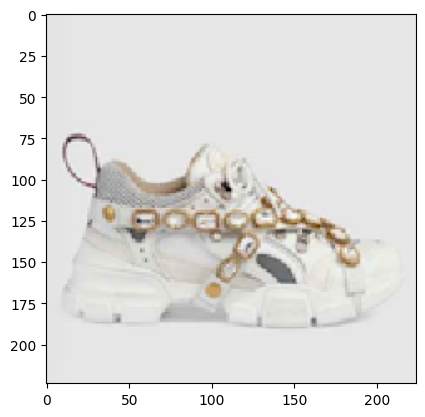

In [ ]:
# vemos imagen aleatoria
import random

idx =  random.randint(0, len(files))
original = load_img(files[idx], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image cargada exitosamente!")

In [ ]:
# convertir PIL image a numpy array
numpy_image = img_to_array(original)

# convertir imagen a batch de imagenes para entrenamiento más eficiente
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# preparamos la imagen para la VGG16
processed_image = preprocess_input(image_batch.copy())

processed_image

image cargada exitosamente!
image batch size (1, 224, 224, 3)


array([[[[122.061, 109.221, 102.32 ],
         [123.061, 110.221, 103.32 ],
         [123.061, 110.221, 103.32 ],
         ...,
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ]],

        [[122.061, 109.221, 102.32 ],
         [123.061, 110.221, 103.32 ],
         [123.061, 110.221, 103.32 ],
         ...,
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ]],

        [[122.061, 109.221, 102.32 ],
         [123.061, 110.221, 103.32 ],
         [123.061, 110.221, 103.32 ],
         ...,
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ],
         [126.061, 113.221, 106.32 ]],

        ...,

        [[123.061, 110.221, 103.32 ],
         [124.061, 111.221, 104.32 ],
         [124.061, 111.221, 104.32 ],
         ...,
         [127.061, 114.221, 107.32 ],
         [127.061, 114.221, 107.32 ],
         [127.061, 114.221, 107.32 ]],

        [[

In [ ]:
# obtenemos los features (embeddings) de las imagenes pasandolas por la VGG16
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
features successfully extracted!
number of image features: 4096


array([[0.18650737, 0.        , 0.        , ..., 4.4707837 , 0.        ,
        1.0713686 ]], dtype=float32)

In [ ]:
img_features.shape

(1, 4096)

In [ ]:
# repetimos el mismo proceso para todas las imagenes y guardamos los batch en una lista para entregarselos procesados a la VGG16
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# obtenemos los features para cada imagen con la CNN
imgs_features = feat_extractor.predict(processed_imgs)

print("features extraidos exitosamente!")
imgs_features.shape

69/69 ━━━━━━━━━━━━━━━━━━━━ 1547s 22s/step
features extraidos exitosamente!


(2184, 4096)

In [ ]:
# computa similaridad coseno entre los features de las imagenes
cosSimilarities = cosine_similarity(imgs_features)

# guardamos los resultados en un dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df #.head()

,images/3_9_020.png,images/3_5_008.png,images/2_0_040.png,images/5_5_007.png,images/2_0_045.png,images/5_7_007.png,images/6_4_015.png,images/0_8_002.png,images/5_2_010.png,images/5_0_037.png,...,images/3_0_078.png,images/1_2_044.png,images/2_0_068.png,images/0_1_012.png,images/1_1_011.png,images/4_6_017.png,images/1_0_014.png,images/1_5_022.png,images/1_2_054.png,images/4_1_054.png
images/3_9_020.png,1.000000,0.262350,0.284818,0.271348,0.201784,0.244936,0.260017,0.168559,0.308571,0.200516,...,0.101886,0.321238,0.194678,0.328997,0.291434,0.323090,0.142291,0.285974,0.245368,0.442894
images/3_5_008.png,0.262350,1.000000,0.285694,0.490505,0.153435,0.273692,0.333201,0.185155,0.152858,0.243673,...,0.141261,0.245345,0.250910,0.241740,0.217369,0.366413,0.267818,0.500347,0.198006,0.244425
images/2_0_040.png,0.284818,0.285694,1.000000,0.301655,0.332258,0.328784,0.434583,0.313469,0.302157,0.478178,...,0.317016,0.462411,0.521095,0.280869,0.204537,0.462892,0.429931,0.363068,0.362320,0.315861
images/5_5_007.png,0.271348,0.490505,0.301655,1.000000,0.192058,0.337969,0.407739,0.126262,0.271814,0.298151,...,0.180069,0.249818,0.306027,0.267372,0.255646,0.367598,0.279311,0.410546,0.266442,0.302796
images/2_0_045.png,0.201784,0.153435,0.332258,0.192058,1.000000,0.334884,0.236231,0.258170,0.284059,0.244076,...,0.188766,0.241293,0.219436,0.264671,0.127739,0.264181,0.319158,0.316869,0.208368,0.129856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/4_6_017.png,0.323090,0.366413,0.462892,0.367598,0.264181,0.374065,0.413702,0.223720,0.267437,0.375969,...,0.288263,0.539825,0.331365,0.394284,0.258969,1.000000,0.504639,0.388926,0.455102,0.321739
images/1_0_014.png,0.142291,0.267818,0.429931,0.279311,0.319158,0.325972,0.338959,0.301899,0.256068,0.381068,...,0.545795,0.542041,0.377014,0.211293,0.176482,0.504639,1.000000,0.418312,0.559243,0.176014
images/1_5_022.png,0.285974,0.500347,0.363068,0.410546,0.316869,0.256975,0.374464,0.209959,0.297361,0.368179,...,0.245439,0.400499,0.310331,0.259355,0.228593,0.388926,0.418312,1.000000,0.362144,0.267046
images/1_2_054.png,0.245368,0.198006,0.362320,0.266442,0.208368,0.226594,0.303679,0.294046,0.493485,0.377778,...,0.237113,0.702223,0.290825,0.235411,0.247765,0.455102,0.559243,0.362144,1.000000,0.286638


In [ ]:
# esta funcion recupera las imagenes más similares dada una imagen entregada por el usuario
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("producto escogido:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("productos más similares:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("score de similaridad : ",closest_imgs_scores[i])

922
images/1_8_010.png
-----------------------------------------------------------------------
producto escogido:


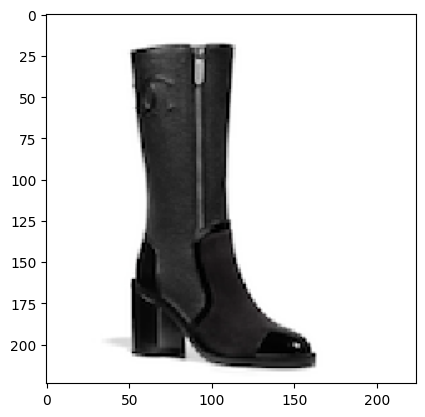

-----------------------------------------------------------------------
productos más similares:


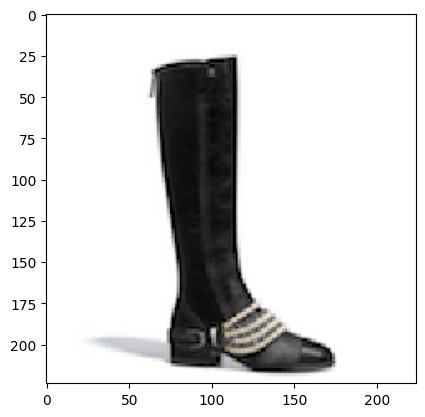

<ipython-input-14-a1c21c155cf9>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("score de similaridad : ",closest_imgs_scores[i])


score de similaridad :  0.8307759


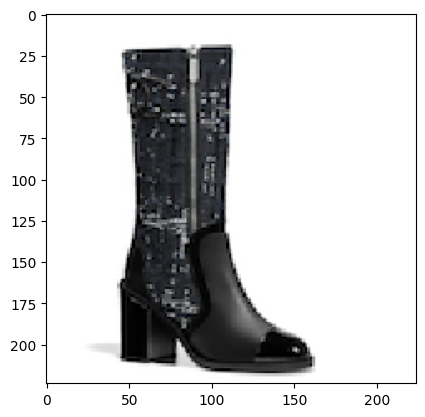

score de similaridad :  0.8220797


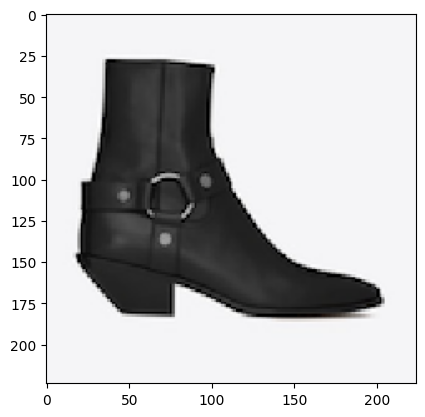

score de similaridad :  0.77429414


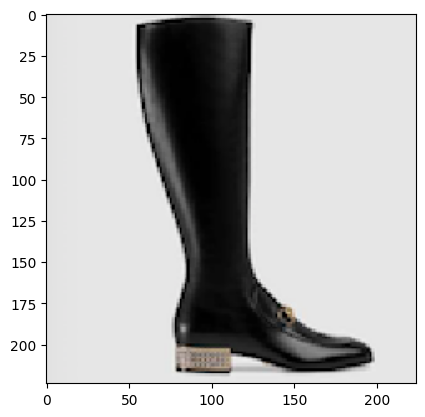

score de similaridad :  0.77092


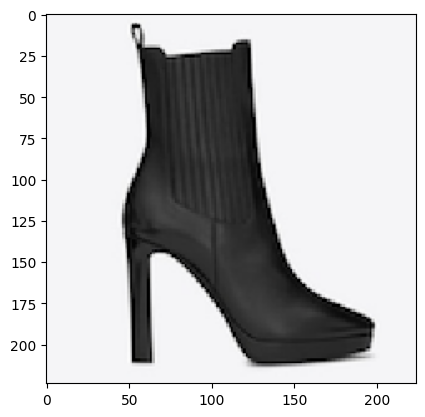

score de similaridad :  0.76765746


In [ ]:
# idx = 1100 # random.randint(0, len(files))
idx = random.randint(0, len(files))
print(idx)
print(files[idx])
retrieve_most_similar_products(files[idx])

# ACTIVIDAD

1. Mostrar 2 ejemplos de búsqueda de imagenes similares utilizando ambas arquitecturas (VGG16 y VGG19) e imprimir los resultados. (3 ptos)

2. ¿Cuál de las dos arquitecturas (VGG16 o VGG19) tiene más parámetros entrenables después de quitar la última capa de clasificación?. Justifique indicando la cantidad de parámetros de cada una. (2 ptos)


##Pregunta 1:

###VGG 16

In [ ]:
# cargamos el modelo escoger

modelo_escogido = 'vgg16' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ls

In [ ]:
imgs_path = "images/" # ruta

imgs_model_width, imgs_model_height = 224, 224 # tamaño de las imagenes 224x224 pixeles

nb_closest_images = 5 # cantidad de imagenes similares a recomendar

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]
print("total de imagenes:",len(files))

In [ ]:
# vemos imagen aleatoria
import random

idx =  random.randint(0, len(files))
original = load_img(files[idx], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image cargada exitosamente!")

In [ ]:
# convertir PIL image a numpy array
numpy_image = img_to_array(original)

# convertir imagen a batch de imagenes para entrenamiento más eficiente
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# preparamos la imagen para la VGG16
processed_image = preprocess_input(image_batch.copy())

processed_image

image batch size (1, 224, 224, 3)


array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [ ]:
# obtenemos los features (embeddings) de las imagenes pasandolas por la VGG16
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.       , ..., 3.5380206, 0.       ,
        1.1148913]], dtype=float32)

In [ ]:
img_features.shape

(1, 4096)

In [ ]:
# repetimos el mismo proceso para todas las imagenes y guardamos los batch en una lista para entregarselos procesados a la VGG16
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# obtenemos los features para cada imagen con la CNN
imgs_features = feat_extractor.predict(processed_imgs)

print("features extraidos exitosamente!")
imgs_features.shape

69/69 ━━━━━━━━━━━━━━━━━━━━ 1228s 18s/step


In [ ]:
# computa similaridad coseno entre los features de las imagenes
cosSimilarities = cosine_similarity(imgs_features)

# guardamos los resultados en un dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df #.head()

,images/3_9_020.png,images/3_5_008.png,images/2_0_040.png,images/5_5_007.png,images/2_0_045.png,images/5_7_007.png,images/6_4_015.png,images/0_8_002.png,images/5_2_010.png,images/5_0_037.png,...,images/3_0_078.png,images/1_2_044.png,images/2_0_068.png,images/0_1_012.png,images/1_1_011.png,images/4_6_017.png,images/1_0_014.png,images/1_5_022.png,images/1_2_054.png,images/4_1_054.png
images/3_9_020.png,1.000000,0.282888,0.336624,0.332648,0.257104,0.319672,0.349310,0.190976,0.350533,0.260464,...,0.128382,0.270583,0.328554,0.434828,0.326793,0.392612,0.231620,0.347147,0.287236,0.403084
images/3_5_008.png,0.282888,1.000000,0.256155,0.422159,0.184500,0.244744,0.280958,0.219074,0.182589,0.234581,...,0.181814,0.331221,0.262649,0.228042,0.226205,0.367860,0.344951,0.546862,0.259965,0.247558
images/2_0_040.png,0.336624,0.256155,1.000000,0.240960,0.342043,0.353876,0.357073,0.282070,0.258213,0.421233,...,0.327327,0.369806,0.574336,0.256112,0.202708,0.369220,0.434286,0.284600,0.268529,0.271065
images/5_5_007.png,0.332648,0.422159,0.240960,1.000000,0.202167,0.360995,0.451248,0.134413,0.290689,0.228660,...,0.161034,0.274245,0.345732,0.241092,0.250658,0.306347,0.295394,0.518455,0.244428,0.254381
images/2_0_045.png,0.257104,0.184500,0.342043,0.202167,1.000000,0.283275,0.233736,0.311101,0.277787,0.307895,...,0.173711,0.287808,0.297502,0.209351,0.140435,0.312062,0.347999,0.307583,0.310880,0.147488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/4_6_017.png,0.392612,0.367860,0.369220,0.306347,0.312062,0.398037,0.399592,0.333313,0.298924,0.393958,...,0.307862,0.545314,0.411177,0.340232,0.231454,1.000000,0.546578,0.442881,0.528942,0.295626
images/1_0_014.png,0.231620,0.344951,0.434286,0.295394,0.347999,0.337943,0.391284,0.364374,0.282932,0.395730,...,0.506106,0.620710,0.534786,0.198008,0.193664,0.546578,1.000000,0.440402,0.562840,0.186619
images/1_5_022.png,0.347147,0.546862,0.284600,0.518455,0.307583,0.315854,0.408928,0.230051,0.290261,0.310406,...,0.210592,0.413685,0.403797,0.256031,0.256606,0.442881,0.440402,1.000000,0.397370,0.241548
images/1_2_054.png,0.287236,0.259965,0.268529,0.244428,0.310880,0.253431,0.325775,0.342774,0.452189,0.351254,...,0.248755,0.734858,0.324437,0.190478,0.281979,0.528942,0.562840,0.397370,1.000000,0.308521


In [ ]:
# esta funcion recupera las imagenes más similares dada una imagen entregada por el usuario
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("producto escogido:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("productos más similares:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("score de similaridad : ",closest_imgs_scores[i])

In [ ]:
# busqueda 1

187
images/1_3_012.png
-----------------------------------------------------------------------
producto escogido:


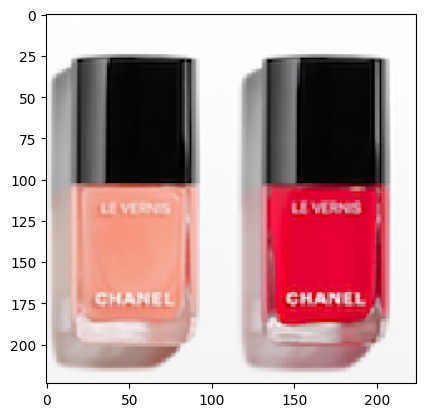

-----------------------------------------------------------------------
productos más similares:


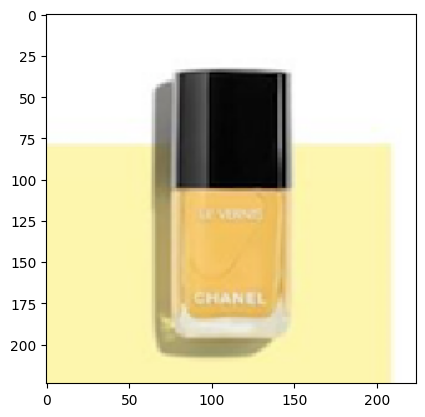

<ipython-input-27-a1c21c155cf9>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("score de similaridad : ",closest_imgs_scores[i])


score de similaridad :  0.9013727


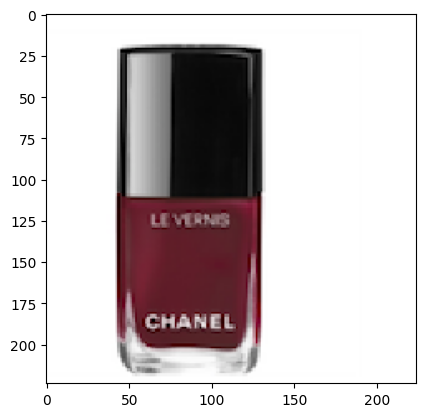

score de similaridad :  0.90111196


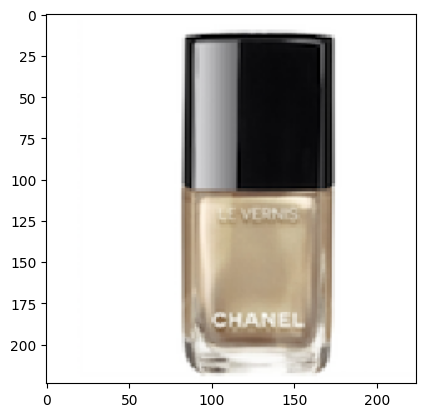

score de similaridad :  0.87731194


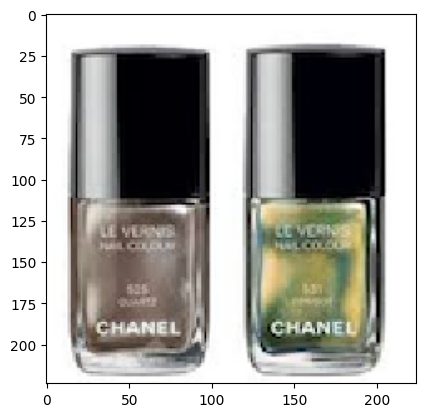

score de similaridad :  0.84592927


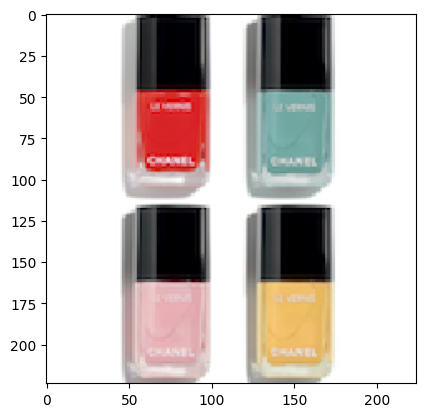

score de similaridad :  0.8374127


In [ ]:
# idx = 1100 # random.randint(0, len(files))
idx = random.randint(0, len(files))
print(idx)
print(files[idx])
retrieve_most_similar_products(files[idx])

In [ ]:
# busqueda 2

1256
images/3_4_001.png
-----------------------------------------------------------------------
producto escogido:


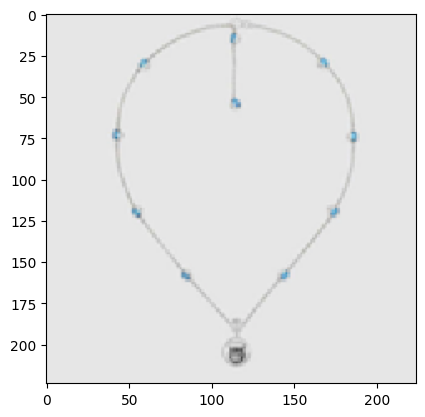

-----------------------------------------------------------------------
productos más similares:


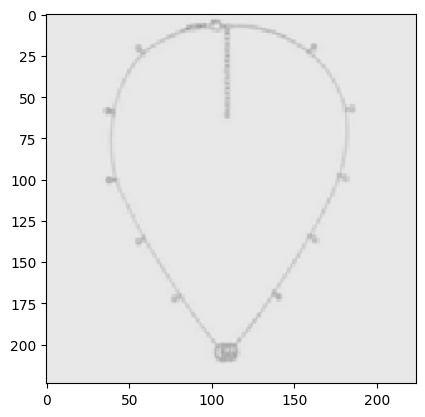

<ipython-input-27-a1c21c155cf9>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("score de similaridad : ",closest_imgs_scores[i])


score de similaridad :  0.8362198


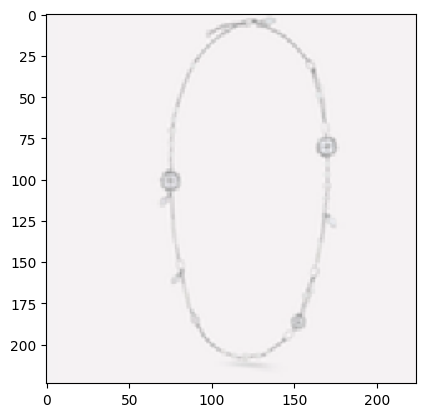

score de similaridad :  0.8002359


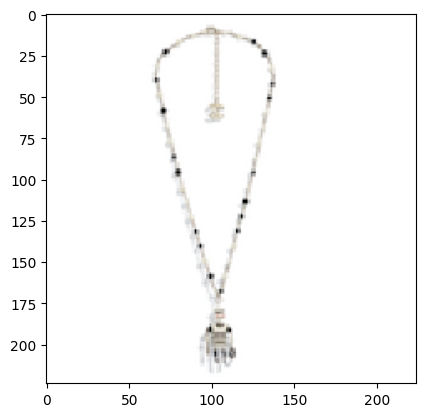

score de similaridad :  0.778157


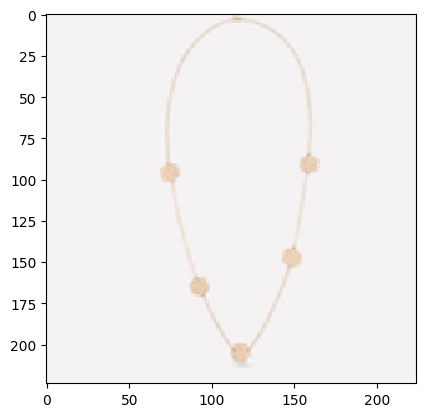

score de similaridad :  0.7763244


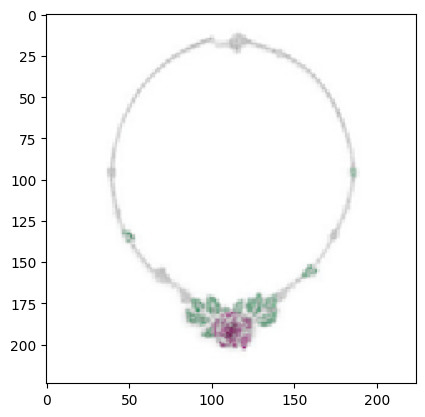

score de similaridad :  0.75506544


In [ ]:
# idx = 1100 # random.randint(0, len(files))
idx = random.randint(0, len(files))
print(idx)
print(files[idx])
retrieve_most_similar_products(files[idx])

###**VGG** 19

In [ ]:
# cargamos el modelo escoger

modelo_escogido = 'vgg19' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ls

images/  images_fashion.zip  __MACOSX/  sample_data/  style.csv  style.txt


In [ ]:
imgs_path = "images/" # ruta

imgs_model_width, imgs_model_height = 224, 224 # tamaño de las imagenes 224x224 pixeles

nb_closest_images = 5 # cantidad de imagenes similares a recomendar

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]
print("total de imagenes:",len(files))

total de imagenes: 2184


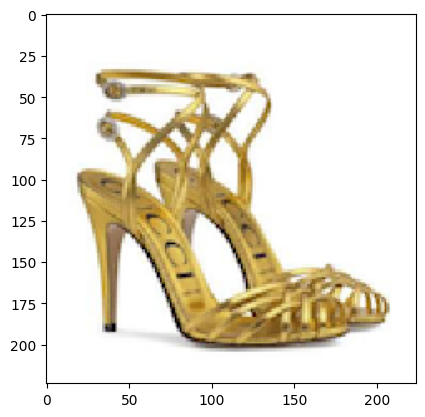

image cargada exitosamente!


In [ ]:
# vemos imagen aleatoria
import random

idx =  random.randint(0, len(files))
original = load_img(files[idx], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image cargada exitosamente!")

In [ ]:
# convertir PIL image a numpy array
numpy_image = img_to_array(original)

# convertir imagen a batch de imagenes para entrenamiento más eficiente
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# preparamos la imagen para la VGG16
processed_image = preprocess_input(image_batch.copy())

processed_image

image batch size (1, 224, 224, 3)


array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [ ]:
# obtenemos los features (embeddings) de las imagenes pasandolas por la VGG16
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
features successfully extracted!
number of image features: 4096


array([[0.       , 4.635034 , 0.       , ..., 0.       , 0.       ,
        0.5598388]], dtype=float32)

In [ ]:
img_features.shape

(1, 4096)

In [ ]:
# repetimos el mismo proceso para todas las imagenes y guardamos los batch en una lista para entregarselos procesados a la VGG16
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [43]:
# obtenemos los features para cada imagen con la CNN
imgs_features = feat_extractor.predict(processed_imgs)

print("features extraidos exitosamente!")
imgs_features.shape

69/69 ━━━━━━━━━━━━━━━━━━━━ 1528s 22s/step
features extraidos exitosamente!


(2184, 4096)

In [44]:
# computa similaridad coseno entre los features de las imagenes
cosSimilarities = cosine_similarity(imgs_features)

# guardamos los resultados en un dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df #.head()

,images/3_9_020.png,images/3_5_008.png,images/2_0_040.png,images/5_5_007.png,images/2_0_045.png,images/5_7_007.png,images/6_4_015.png,images/0_8_002.png,images/5_2_010.png,images/5_0_037.png,...,images/3_0_078.png,images/1_2_044.png,images/2_0_068.png,images/0_1_012.png,images/1_1_011.png,images/4_6_017.png,images/1_0_014.png,images/1_5_022.png,images/1_2_054.png,images/4_1_054.png
images/3_9_020.png,1.000000,0.262350,0.284818,0.271348,0.201784,0.244936,0.260017,0.168559,0.308571,0.200516,...,0.101886,0.321238,0.194678,0.328997,0.291434,0.323090,0.142291,0.285974,0.245368,0.442894
images/3_5_008.png,0.262350,1.000000,0.285694,0.490505,0.153435,0.273692,0.333201,0.185155,0.152858,0.243673,...,0.141261,0.245345,0.250910,0.241740,0.217369,0.366413,0.267818,0.500347,0.198006,0.244425
images/2_0_040.png,0.284818,0.285694,1.000000,0.301655,0.332258,0.328784,0.434583,0.313469,0.302157,0.478178,...,0.317016,0.462411,0.521095,0.280869,0.204537,0.462892,0.429931,0.363068,0.362320,0.315861
images/5_5_007.png,0.271348,0.490505,0.301655,1.000000,0.192058,0.337969,0.407739,0.126262,0.271814,0.298151,...,0.180069,0.249818,0.306027,0.267372,0.255646,0.367598,0.279311,0.410546,0.266442,0.302796
images/2_0_045.png,0.201784,0.153435,0.332258,0.192058,1.000000,0.334884,0.236231,0.258170,0.284059,0.244076,...,0.188766,0.241293,0.219436,0.264671,0.127739,0.264181,0.319158,0.316869,0.208368,0.129856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/4_6_017.png,0.323090,0.366413,0.462892,0.367598,0.264181,0.374065,0.413702,0.223720,0.267437,0.375969,...,0.288263,0.539825,0.331365,0.394284,0.258969,1.000000,0.504639,0.388926,0.455102,0.321739
images/1_0_014.png,0.142291,0.267818,0.429931,0.279311,0.319158,0.325972,0.338959,0.301899,0.256068,0.381068,...,0.545795,0.542041,0.377014,0.211293,0.176482,0.504639,1.000000,0.418312,0.559243,0.176014
images/1_5_022.png,0.285974,0.500347,0.363068,0.410546,0.316869,0.256975,0.374464,0.209959,0.297361,0.368179,...,0.245439,0.400499,0.310331,0.259355,0.228593,0.388926,0.418312,1.000000,0.362144,0.267046
images/1_2_054.png,0.245368,0.198006,0.362320,0.266442,0.208368,0.226594,0.303679,0.294046,0.493485,0.377778,...,0.237113,0.702223,0.290825,0.235411,0.247765,0.455102,0.559243,0.362144,1.000000,0.286638


In [45]:
# esta funcion recupera las imagenes más similares dada una imagen entregada por el usuario
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("producto escogido:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("productos más similares:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("score de similaridad : ",closest_imgs_scores[i])

In [46]:
# busqueda 1

66
images/0_3_009.png
-----------------------------------------------------------------------
producto escogido:


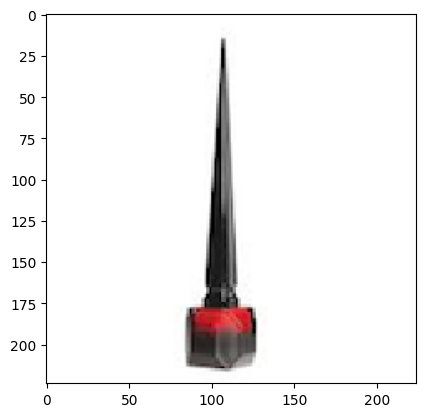

-----------------------------------------------------------------------
productos más similares:


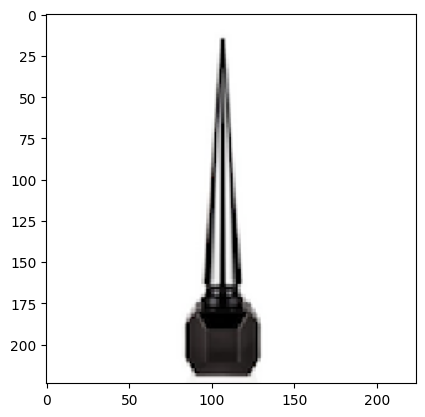

<ipython-input-45-a1c21c155cf9>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("score de similaridad : ",closest_imgs_scores[i])


score de similaridad :  0.8783078


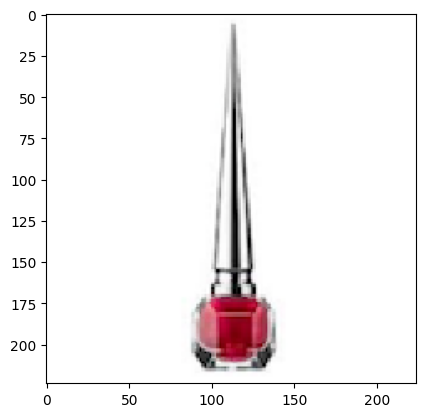

score de similaridad :  0.86701506


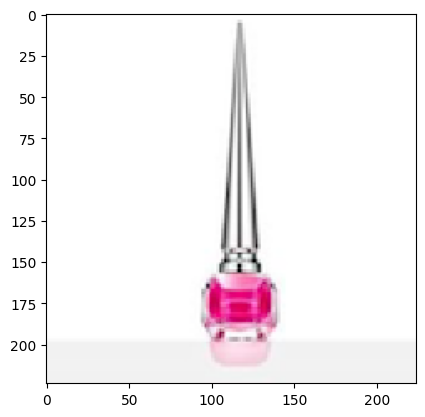

score de similaridad :  0.8320741


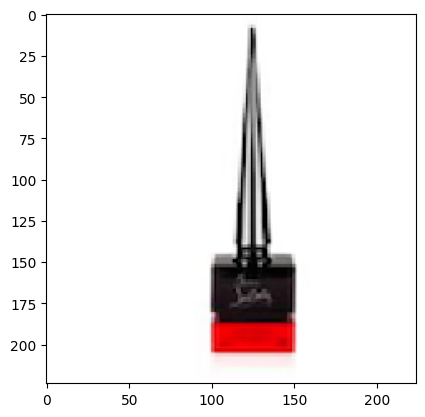

score de similaridad :  0.8283677


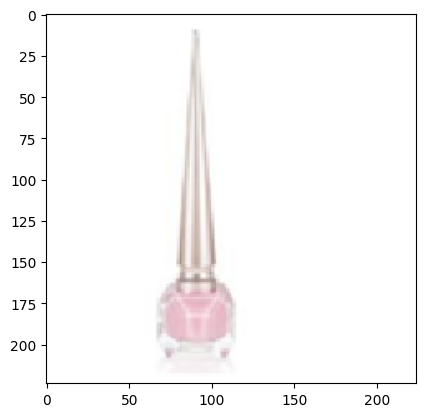

score de similaridad :  0.77573085


In [47]:
# idx = 1100 # random.randint(0, len(files))
idx = random.randint(0, len(files))
print(idx)
print(files[idx])
retrieve_most_similar_products(files[idx])

In [48]:
# busqueda 2

1122
images/1_5_011.png
-----------------------------------------------------------------------
producto escogido:


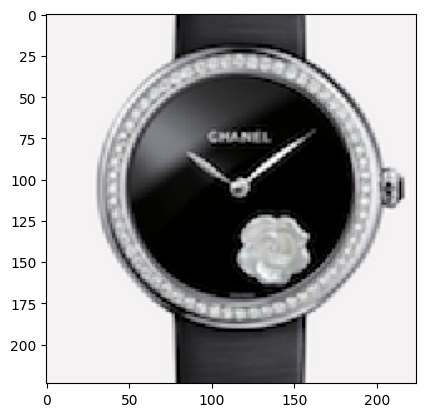

-----------------------------------------------------------------------
productos más similares:


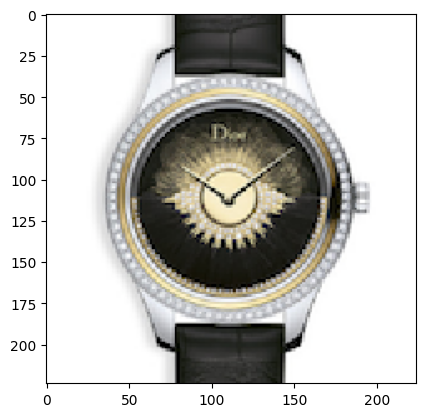

<ipython-input-45-a1c21c155cf9>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("score de similaridad : ",closest_imgs_scores[i])


score de similaridad :  0.72299457


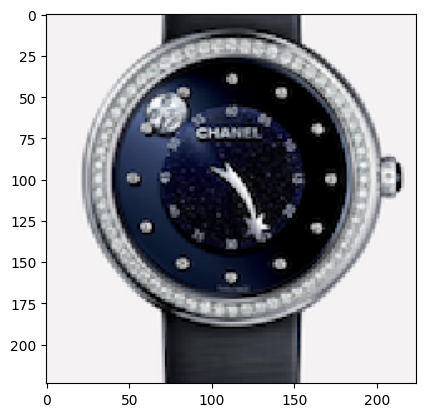

score de similaridad :  0.6836288


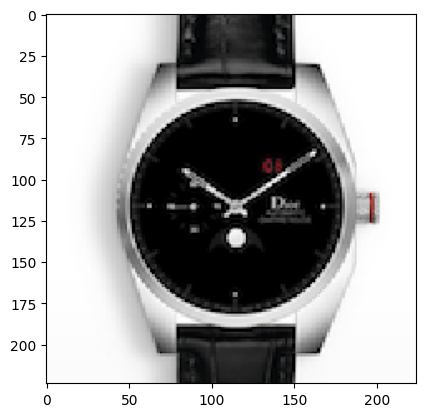

score de similaridad :  0.6829218


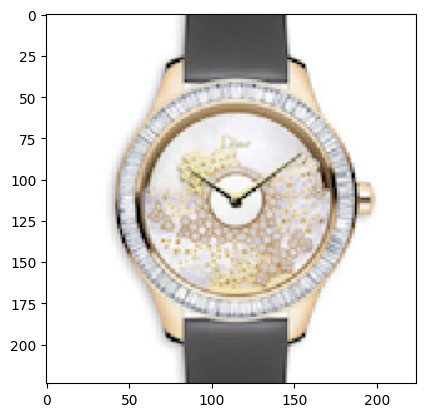

score de similaridad :  0.6784216


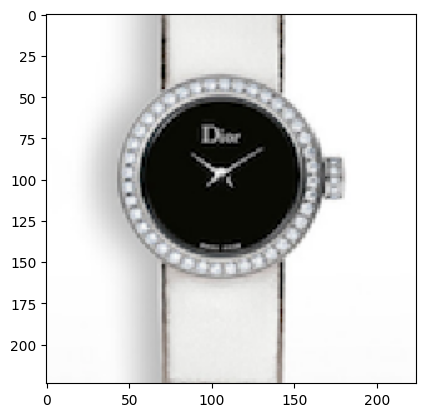

score de similaridad :  0.6750993


In [49]:
# idx = 1100 # random.randint(0, len(files))
idx = random.randint(0, len(files))
print(idx)
print(files[idx])
retrieve_most_similar_products(files[idx])

##Pregunta 2
- parametros entrenables VGG16 sin ultima capa
- parametros entrenables VGG19 sin ultima capa




In [50]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model

def get_trainable_params(model_name):
    if model_name == 'vgg16':
        vgg_model = VGG16(weights='imagenet')
        feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)
    elif model_name == 'vgg19':
        vgg_model = VGG19(weights='imagenet')
        feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)

    # Resumen del modelo para ver los parámetros entrenables
    feat_extractor.summary()

get_trainable_params('vgg16')  # Para VGG16
get_trainable_params('vgg19')  # Para VGG19


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

Con los resultados que obtuvimos del resumen de los modelos, aquí están los detalles para el número de parámetros entrenables de VGG16 y VGG19 después de eliminar la última capa de clasificación:

`VGG16:`
*   Total de Parámetros: 134,260,544
*   `Parámetros Entrenables: 134,260,544`
*   Parámetros No Entrenables: 0

`VGG19:`
*   Total de Parámetros: 139,570,240
*   `Parámetros Entrenables: 139,570,240`
*   Parámetros No Entrenables: 0

VGG19 tiene más parámetros entrenables que VGG16, incluso después de eliminar la última capa de clasificación. La diferencia se debe a que VGG19 tiene más capas convolucionales, lo que aumenta el número total de parámetros.